# let's calculate RUWE like a lot of times really quickly

Benjamin Pennell

--

Max Planck Institut für Astronomie, Heidelberg

---

In [1]:
import numpy as np
import GaiamockWrapper as gw
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Imagine, if you will, that you have proposed a binary

In [2]:
period = 1e3 # days
m1 = 1.2
q = 0.7
parallax = 5
phot_g_mean_mag = 13
ra = 30
dec = 30
pmra = 0
pmdec = 0
ecc = 0
f = 1e-2

and then you want to efficiently see how RUWE will change as the orbital angles change, we'll want to call ruwe like a bunch of times

In [3]:
ruwes = []

for i in tqdm(range(10000)):
    # choose random angles
    w = np.random.rand()*2*np.pi
    omega = np.random.rand()*2*np.pi
    inc = np.random.rand()*0.5*np.pi
    Tp = np.random.rand()-0.5 
    
    # calculate ruwe
    ruwes.append(gw.calculate_ruwe(period=period, m1=m1, q=q, parallax=parallax, phot_g_mean_mag=phot_g_mean_mag, 
                                   ra=ra, dec=dec, pmra=pmra, pmdec=pmdec, ecc=ecc, f=f,
                                   w=w, omega=omega, inc=inc, Tp=Tp))

  0%|          | 0/10000 [00:00<?, ?it/s]

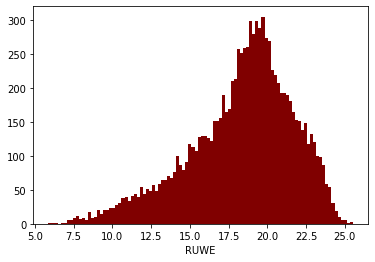

In [4]:
plt.hist(ruwes, bins=100, color="maroon");
plt.xlabel("RUWE");

on my laptop this took ~30 seconds to run

that's all well and good but it can be sped up. `fr.calculate_ruwe()` already has some of `gaiamock`'s fat trimmed out, but we can do more by precomputing part of the astrometry

In [5]:
t_ast_yr, psi, plx_factor, epoch_err_per_transit = gw.astrometry_setup(ra, dec, phot_g_mean_mag, data_release="dr3")

ruwes = []
for i in tqdm(range(10000)):
    # choose random angles
    w = np.random.rand()*2*np.pi
    omega = np.random.rand()*2*np.pi
    inc = np.random.rand()*0.5*np.pi
    Tp = np.random.rand()-0.5 
    
    # calculate ruwe
    ruwes.append(gw.calculate_ruwe(t_ast_yr=t_ast_yr, psi=psi, plx_factor=plx_factor, epoch_err_per_transit=epoch_err_per_transit,
                                phot_g_mean_mag=phot_g_mean_mag, period=period, m1=m1, q=q, parallax=parallax, 
                                pmra=pmra, pmdec=pmdec, ecc=ecc, f=f,
                                w=w, omega=omega, inc=inc, Tp=Tp))

  0%|          | 0/10000 [00:00<?, ?it/s]

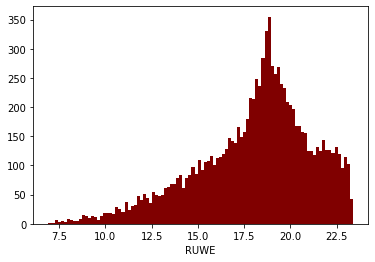

In [6]:
plt.hist(ruwes, bins=100, color="maroon");
plt.xlabel("RUWE");

On my laptop this took ~1.1s to run. look at that efficiency :)

But you'll notice the precomputed version has a sharper peak. `gaiamock` drops off 10% of the obserations randomly, and this is something that I'm precomputing. So, in the faster case here, it's simulating how RUWE would change *under the same observing conditions*

For this reason, the extra added noise when `phot_g_mean_mag < 13` was kept on-the-fly since to me this seems like it should vary.

But, I could change either of these, just let me know.